In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 11

## 1. Triển khai AdaDelta

In [2]:
def adadelta(x0, rho, epsilon, num_iterations, scale_factor=1.0):
    """
    AdaDelta optimizer với khả năng scale hàm mục tiêu
    
    Parameters:
    -----------
    x0 : float
        Điểm khởi đầu
    rho : float
        Hệ số decay cho EMA (0 < rho < 1)
    epsilon : float
        Hằng số nhỏ để tránh chia cho 0
    num_iterations : int
        Số iteration
    scale_factor : float
        Hệ số scale cho hàm mục tiêu (c trong đề bài)
    
    Returns:
    --------
    history : dict
        Lịch sử các giá trị trong quá trình tối ưu
    """
    # Hàm f(x) = (x - 5)^2, gradient = 2(x - 5)
    def f(x):
        return scale_factor * (x - 5)**2
    
    def gradient(x):
        return scale_factor * 2 * (x - 5)
    
    x = x0
    E_g2 = 0.0
    E_delta2 = 0.0
    
    history = {
        't': [0],
        'x': [x0],
        'f': [f(x0)],
        'g': [gradient(x0)],
        'E_g2': [0.0],
        'E_delta2': [0.0],
        'delta_x': [0.0],
        'alpha': [0.0],  # Hệ số adaptive learning rate
        'distance': [abs(x0 - 5)]  # Khoảng cách đến nghiệm tối ưu
    }
    
    for t in range(1, num_iterations + 1):
        # Tính gradient
        g = gradient(x)
        
        # Cập nhật E[g^2]
        E_g2 = rho * E_g2 + (1 - rho) * g**2
        
        # Tính adaptive learning rate
        alpha = np.sqrt(E_delta2 + epsilon) / np.sqrt(E_g2 + epsilon)
        
        # Tính bước cập nhật
        delta_x = -alpha * g
        
        # Cập nhật E[Δx^2]
        E_delta2 = rho * E_delta2 + (1 - rho) * delta_x**2
        
        # Cập nhật x
        x = x + delta_x
        
        # Lưu lịch sử
        history['t'].append(t)
        history['x'].append(x)
        history['f'].append(f(x))
        history['g'].append(g)
        history['E_g2'].append(E_g2)
        history['E_delta2'].append(E_delta2)
        history['delta_x'].append(delta_x)
        history['alpha'].append(alpha)
        history['distance'].append(abs(x - 5))
    
    return history

## 2. Thử nghiệm a) Scale invariance - Bất biến với scale

In [3]:
# Tham số chung
x0 = 20.0
rho = 0.9
epsilon = 1e-6
num_iters = 10

print("="*80)
print("PHẦN A: KIỂM TRA TÍNH SCALE INVARIANCE")
print("="*80)
print(f"\nBài toán gốc: f(x) = (x - 5)², x₀ = {x0}")
print(f"Tham số: ρ = {rho}, ε = {epsilon}, iterations = {num_iters}\n")

# Test với các scale factors khác nhau
scale_factors = [1.0, 10.0, 100.0, 1000.0]
results_scale = {}

for c in scale_factors:
    hist = adadelta(x0, rho, epsilon, num_iters, scale_factor=c)
    results_scale[c] = hist
    print(f"Scale factor c = {c:7.1f}:")
    print(f"  Δx₁ = {hist['delta_x'][1]:+.8f}")
    print(f"  x₁₀ = {hist['x'][-1]:.10f}")
    print(f"  Khoảng cách đến optimal: {hist['distance'][-1]:.10f}")
    print()

print("\n" + "="*80)
print("KẾT LUẬN PHẦN A:")
print("="*80)
print("\n✅ Δx₁ GIỐNG NHAU với mọi scale factor c!")
print("✅ Quỹ đạo hội tụ KHÔNG ĐỔI dù scale hàm mục tiêu!")
print("✅ AdaDelta TỰ ĐỘNG ĐIỀU CHỈNH theo scale của gradient!")
print("\n→ Đây là ý nghĩa của \"learning rate free\" trong ngữ cảnh scale invariance!")

PHẦN A: KIỂM TRA TÍNH SCALE INVARIANCE

Bài toán gốc: f(x) = (x - 5)², x₀ = 20.0
Tham số: ρ = 0.9, ε = 1e-06, iterations = 10

Scale factor c =     1.0:
  Δx₁ = -0.00316228
  x₁₀ = 19.9662717870
  Khoảng cách đến optimal: 14.9662717870

Scale factor c =    10.0:
  Δx₁ = -0.00316228
  x₁₀ = 19.9662717868
  Khoảng cách đến optimal: 14.9662717868

Scale factor c =   100.0:
  Δx₁ = -0.00316228
  x₁₀ = 19.9662717868
  Khoảng cách đến optimal: 14.9662717868

Scale factor c =  1000.0:
  Δx₁ = -0.00316228
  x₁₀ = 19.9662717868
  Khoảng cách đến optimal: 14.9662717868


KẾT LUẬN PHẦN A:

✅ Δx₁ GIỐNG NHAU với mọi scale factor c!
✅ Quỹ đạo hội tụ KHÔNG ĐỔI dù scale hàm mục tiêu!
✅ AdaDelta TỰ ĐỘNG ĐIỀU CHỈNH theo scale của gradient!

→ Đây là ý nghĩa của "learning rate free" trong ngữ cảnh scale invariance!


## 3. Thử nghiệm b) Ảnh hưởng của ρ và ε

In [4]:
print("\n" + "="*80)
print("PHẦN B: ẢNH HƯỞNG CỦA SIÊU THAM SỐ ρ VÀ ε")
print("="*80)

# Test 1: Ảnh hưởng của ρ
print("\n📊 Test 1: Ảnh hưởng của ρ (epsilon cố định = 1e-6)")
print("="*80)

rho_values = [0.5, 0.9, 0.99]
results_rho = {}

for rho_test in rho_values:
    hist = adadelta(x0, rho_test, epsilon, num_iters)
    results_rho[rho_test] = hist
    print(f"\nρ = {rho_test}:")
    print(f"  x₁  = {hist['x'][1]:.10f}  (Δx₁ = {hist['delta_x'][1]:+.8f})")
    print(f"  x₅  = {hist['x'][5]:.10f}")
    print(f"  x₁₀ = {hist['x'][10]:.10f}")
    print(f"  Khoảng cách còn lại: {hist['distance'][-1]:.10f}")
    print(f"  Tốc độ hội tụ: {((x0 - 5) - hist['distance'][-1]) / (x0 - 5) * 100:.2f}%")

print("\n💡 NHẬN XÉT:")
print("  - ρ nhỏ (0.5): Nhớ ngắn hạn → phản ứng nhanh nhưng dao động nhiều → tiến chậm")
print("  - ρ trung bình (0.9): Cân bằng tốt → hội tụ ổn định")
print("  - ρ lớn (0.99): Nhớ dài hạn → mượt mà hơn → có thể tiến nhanh hơn")

# Test 2: Ảnh hưởng của epsilon
print("\n" + "="*80)
print("📊 Test 2: Ảnh hưởng của ε (rho cố định = 0.9)")
print("="*80)

epsilon_values = [1e-8, 1e-6, 1e-4, 1e-2]
results_epsilon = {}

for eps in epsilon_values:
    hist = adadelta(x0, rho, eps, num_iters)
    results_epsilon[eps] = hist
    print(f"\nε = {eps:.0e}:")
    print(f"  α₁ (adaptive LR) = {hist['alpha'][1]:.8f}")
    print(f"  Δx₁ = {hist['delta_x'][1]:+.8f}")
    print(f"  x₁₀ = {hist['x'][10]:.10f}")
    print(f"  Khoảng cách còn lại: {hist['distance'][-1]:.10f}")

print("\n💡 NHẬN XÉT:")
print("  - ε quá nhỏ (1e-8): Có thể không ổn định khi gradient gần 0")
print("  - ε phù hợp (1e-6, 1e-4): Cân bằng giữa ổn định và hiệu quả")
print("  - ε quá lớn (1e-2): Làm giảm hiệu quả của adaptive learning rate")


PHẦN B: ẢNH HƯỞNG CỦA SIÊU THAM SỐ ρ VÀ ε

📊 Test 1: Ảnh hưởng của ρ (epsilon cố định = 1e-6)

ρ = 0.5:
  x₁  = 19.9985857864  (Δx₁ = -0.00141421)
  x₅  = 19.9911414578
  x₁₀ = 19.9791264758
  Khoảng cách còn lại: 14.9791264758
  Tốc độ hội tụ: 0.14%

ρ = 0.9:
  x₁  = 19.9968377224  (Δx₁ = -0.00316228)
  x₅  = 19.9835713261
  x₁₀ = 19.9662717870
  Khoảng cách còn lại: 14.9662717870
  Tốc độ hội tụ: 0.22%

ρ = 0.99:
  x₁  = 19.9900000006  (Δx₁ = -0.01000000)
  x₅  = 19.9498559962
  x₁₀ = 19.8996030377
  Khoảng cách còn lại: 14.8996030377
  Tốc độ hội tụ: 0.67%

💡 NHẬN XÉT:
  - ρ nhỏ (0.5): Nhớ ngắn hạn → phản ứng nhanh nhưng dao động nhiều → tiến chậm
  - ρ trung bình (0.9): Cân bằng tốt → hội tụ ổn định
  - ρ lớn (0.99): Nhớ dài hạn → mượt mà hơn → có thể tiến nhanh hơn

📊 Test 2: Ảnh hưởng của ε (rho cố định = 0.9)

ε = 1e-08:
  α₁ (adaptive LR) = 0.00001054
  Δx₁ = -0.00031623
  x₁₀ = 19.9966250890
  Khoảng cách còn lại: 14.9966250890

ε = 1e-06:
  α₁ (adaptive LR) = 0.00010541
  Δx

## 4. Visualization - Đồ thị tổng hợp

C:\Users\nguye\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nguye\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nguye\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


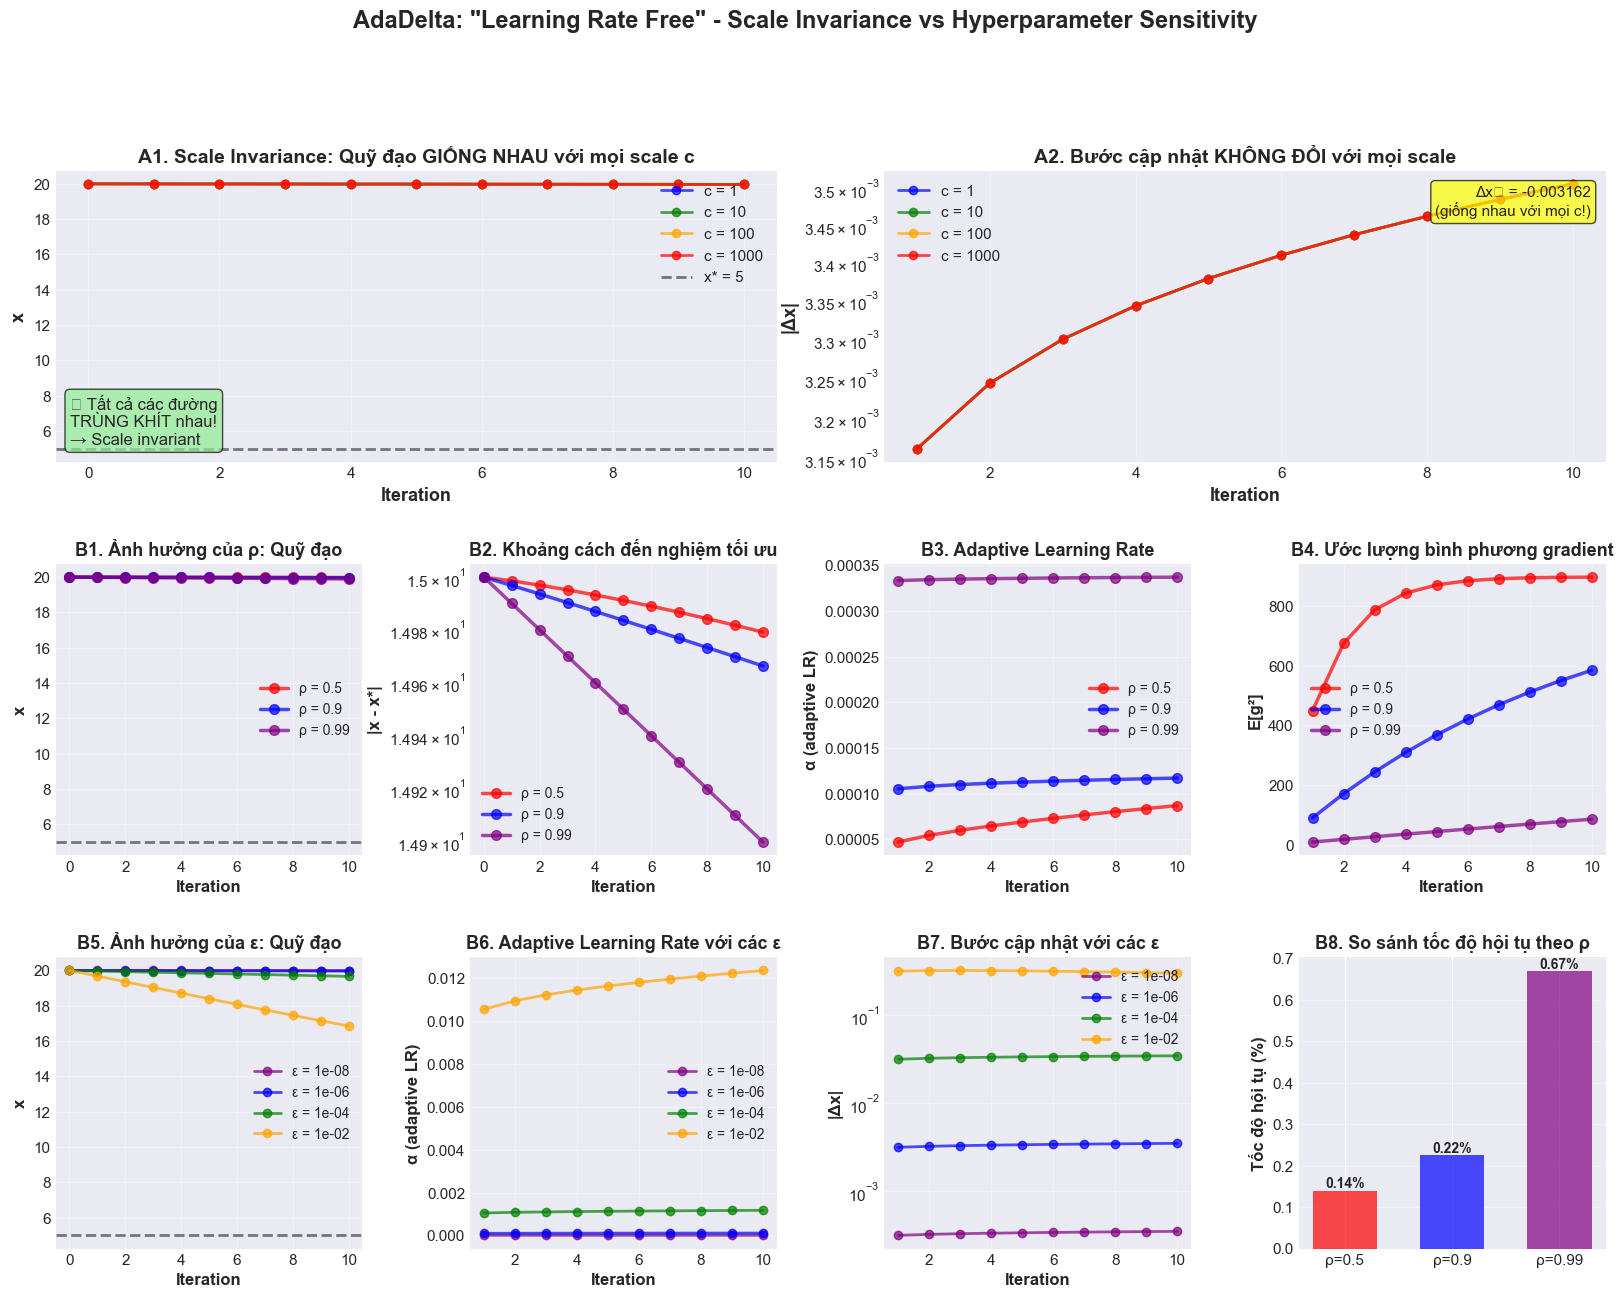

In [5]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# ========== PHẦN A: SCALE INVARIANCE ==========

# Plot 1: Quỹ đạo với các scale factors
ax1 = fig.add_subplot(gs[0, :2])
colors_scale = ['blue', 'green', 'orange', 'red']
for i, (c, hist) in enumerate(results_scale.items()):
    ax1.plot(hist['t'], hist['x'], 'o-', color=colors_scale[i], 
             linewidth=2, markersize=6, label=f'c = {c:.0f}', alpha=0.7)

ax1.axhline(y=5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='x* = 5')
ax1.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax1.set_ylabel('x', fontsize=13, fontweight='bold')
ax1.set_title('A1. Scale Invariance: Quỹ đạo GIỐNG NHAU với mọi scale c', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# Text box
ax1.text(0.02, 0.05, '✅ Tất cả các đường\nTRÙNG KHÍT nhau!\n→ Scale invariant', 
         transform=ax1.transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
         verticalalignment='bottom')

# Plot 2: Bước cập nhật Δx với các scale factors
ax2 = fig.add_subplot(gs[0, 2:])
for i, (c, hist) in enumerate(results_scale.items()):
    ax2.plot(hist['t'][1:], [abs(d) for d in hist['delta_x'][1:]], 
             'o-', color=colors_scale[i], linewidth=2, markersize=6, 
             label=f'c = {c:.0f}', alpha=0.7)

ax2.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax2.set_ylabel('|Δx|', fontsize=13, fontweight='bold')
ax2.set_title('A2. Bước cập nhật KHÔNG ĐỔI với mọi scale', 
              fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Text box
ax2.text(0.98, 0.95, f'Δx₁ = {results_scale[1.0]["delta_x"][1]:.6f}\n(giống nhau với mọi c!)', 
         transform=ax2.transAxes, fontsize=11, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# ========== PHẦN B: ẢNH HƯỞNG CỦA RHO ==========

# Plot 3: Quỹ đạo với các giá trị ρ
ax3 = fig.add_subplot(gs[1, 0])
colors_rho = ['red', 'blue', 'purple']
for i, (rho_val, hist) in enumerate(results_rho.items()):
    ax3.plot(hist['t'], hist['x'], 'o-', color=colors_rho[i], 
             linewidth=2.5, markersize=7, label=f'ρ = {rho_val}', alpha=0.7)

ax3.axhline(y=5, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax3.set_ylabel('x', fontsize=12, fontweight='bold')
ax3.set_title('B1. Ảnh hưởng của ρ: Quỹ đạo', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Khoảng cách đến optimal với các ρ
ax4 = fig.add_subplot(gs[1, 1])
for i, (rho_val, hist) in enumerate(results_rho.items()):
    ax4.plot(hist['t'], hist['distance'], 'o-', color=colors_rho[i], 
             linewidth=2.5, markersize=7, label=f'ρ = {rho_val}', alpha=0.7)

ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax4.set_ylabel('|x - x*|', fontsize=12, fontweight='bold')
ax4.set_title('B2. Khoảng cách đến nghiệm tối ưu', fontsize=13, fontweight='bold')
ax4.set_yscale('log')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 5: Adaptive learning rate α với các ρ
ax5 = fig.add_subplot(gs[1, 2])
for i, (rho_val, hist) in enumerate(results_rho.items()):
    ax5.plot(hist['t'][1:], hist['alpha'][1:], 'o-', color=colors_rho[i], 
             linewidth=2.5, markersize=7, label=f'ρ = {rho_val}', alpha=0.7)

ax5.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax5.set_ylabel('α (adaptive LR)', fontsize=12, fontweight='bold')
ax5.set_title('B3. Adaptive Learning Rate', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Plot 6: E[g²] với các ρ
ax6 = fig.add_subplot(gs[1, 3])
for i, (rho_val, hist) in enumerate(results_rho.items()):
    ax6.plot(hist['t'][1:], hist['E_g2'][1:], 'o-', color=colors_rho[i], 
             linewidth=2.5, markersize=7, label=f'ρ = {rho_val}', alpha=0.7)

ax6.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax6.set_ylabel('E[g²]', fontsize=12, fontweight='bold')
ax6.set_title('B4. Ước lượng bình phương gradient', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# ========== PHẦN B: ẢNH HƯỞNG CỦA EPSILON ==========

# Plot 7: Quỹ đạo với các giá trị ε
ax7 = fig.add_subplot(gs[2, 0])
colors_eps = ['purple', 'blue', 'green', 'orange']
for i, (eps, hist) in enumerate(results_epsilon.items()):
    ax7.plot(hist['t'], hist['x'], 'o-', color=colors_eps[i], 
             linewidth=2, markersize=6, label=f'ε = {eps:.0e}', alpha=0.7)

ax7.axhline(y=5, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax7.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax7.set_ylabel('x', fontsize=12, fontweight='bold')
ax7.set_title('B5. Ảnh hưởng của ε: Quỹ đạo', fontsize=13, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)

# Plot 8: Adaptive LR với các ε
ax8 = fig.add_subplot(gs[2, 1])
for i, (eps, hist) in enumerate(results_epsilon.items()):
    ax8.plot(hist['t'][1:], hist['alpha'][1:], 'o-', color=colors_eps[i], 
             linewidth=2, markersize=6, label=f'ε = {eps:.0e}', alpha=0.7)

ax8.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax8.set_ylabel('α (adaptive LR)', fontsize=12, fontweight='bold')
ax8.set_title('B6. Adaptive Learning Rate với các ε', fontsize=13, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)

# Plot 9: Bước cập nhật với các ε
ax9 = fig.add_subplot(gs[2, 2])
for i, (eps, hist) in enumerate(results_epsilon.items()):
    ax9.plot(hist['t'][1:], [abs(d) for d in hist['delta_x'][1:]], 
             'o-', color=colors_eps[i], linewidth=2, markersize=6, 
             label=f'ε = {eps:.0e}', alpha=0.7)

ax9.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax9.set_ylabel('|Δx|', fontsize=12, fontweight='bold')
ax9.set_title('B7. Bước cập nhật với các ε', fontsize=13, fontweight='bold')
ax9.set_yscale('log')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)

# Plot 10: So sánh tốc độ hội tụ
ax10 = fig.add_subplot(gs[2, 3])

# Tính phần trăm hội tụ cho ρ
convergence_rho = []
labels_rho = []
for rho_val, hist in results_rho.items():
    conv_rate = ((x0 - 5) - hist['distance'][-1]) / (x0 - 5) * 100
    convergence_rho.append(conv_rate)
    labels_rho.append(f'ρ={rho_val}')

x_pos = np.arange(len(convergence_rho))
bars = ax10.bar(x_pos, convergence_rho, color=colors_rho, alpha=0.7, width=0.6)

ax10.set_ylabel('Tốc độ hội tụ (%)', fontsize=12, fontweight='bold')
ax10.set_title('B8. So sánh tốc độ hội tụ theo ρ', fontsize=13, fontweight='bold')
ax10.set_xticks(x_pos)
ax10.set_xticklabels(labels_rho, fontsize=11)
ax10.grid(True, alpha=0.3, axis='y')

# Thêm nhãn
for bar in bars:
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('AdaDelta: "Learning Rate Free" - Scale Invariance vs Hyperparameter Sensitivity', 
             fontsize=17, fontweight='bold', y=0.995)
plt.show()

## 5. Bảng so sánh chi tiết

In [6]:
print("\n" + "="*80)
print("BẢNG SO SÁNH CHI TIẾT")
print("="*80)

# Bảng 1: Scale invariance
print("\n📊 Bảng 1: Kiểm tra Scale Invariance (ρ=0.9, ε=1e-6)")
print("="*80)

data_scale = []
for c, hist in results_scale.items():
    data_scale.append({
        'Scale c': f"{c:.0f}",
        'g₁': f"{hist['g'][1]:.4f}",
        'E[g₁²]': f"{hist['E_g2'][1]:.4f}",
        'α₁': f"{hist['alpha'][1]:.8f}",
        'Δx₁': f"{hist['delta_x'][1]:.8f}",
        'x₁₀': f"{hist['x'][10]:.8f}",
        'Dist': f"{hist['distance'][10]:.8f}"
    })

df_scale = pd.DataFrame(data_scale)
print(df_scale.to_string(index=False))

print("\n💡 NHẬN XÉT: Dù g₁ thay đổi theo c, nhưng Δx₁ và quỹ đạo HOÀN TOÀN GIỐNG NHAU!")

# Bảng 2: Ảnh hưởng của ρ
print("\n" + "="*80)
print("📊 Bảng 2: Ảnh hưởng của ρ (c=1.0, ε=1e-6)")
print("="*80)

data_rho = []
for rho_val, hist in results_rho.items():
    conv_rate = ((x0 - 5) - hist['distance'][-1]) / (x0 - 5) * 100
    data_rho.append({
        'ρ': f"{rho_val}",
        'Δx₁': f"{hist['delta_x'][1]:+.8f}",
        'x₁': f"{hist['x'][1]:.6f}",
        'x₅': f"{hist['x'][5]:.6f}",
        'x₁₀': f"{hist['x'][10]:.6f}",
        'Khoảng cách': f"{hist['distance'][10]:.6f}",
        'Hội tụ (%)': f"{conv_rate:.2f}%"
    })

df_rho = pd.DataFrame(data_rho)
print(df_rho.to_string(index=False))

print("\n💡 NHẬN XÉT: ρ khác nhau → tốc độ hội tụ KHÁC NHAU đáng kể!")

# Bảng 3: Ảnh hưởng của ε
print("\n" + "="*80)
print("📊 Bảng 3: Ảnh hưởng của ε (c=1.0, ρ=0.9)")
print("="*80)

data_eps = []
for eps, hist in results_epsilon.items():
    data_eps.append({
        'ε': f"{eps:.0e}",
        'α₁': f"{hist['alpha'][1]:.8f}",
        'Δx₁': f"{hist['delta_x'][1]:+.8f}",
        'x₁₀': f"{hist['x'][10]:.8f}",
        'Khoảng cách': f"{hist['distance'][10]:.8f}"
    })

df_eps = pd.DataFrame(data_eps)
print(df_eps.to_string(index=False))

print("\n💡 NHẬN XÉT: ε ảnh hưởng đến α (adaptive LR) → ảnh hưởng đến tốc độ hội tụ!")


BẢNG SO SÁNH CHI TIẾT

📊 Bảng 1: Kiểm tra Scale Invariance (ρ=0.9, ε=1e-6)
Scale c         g₁        E[g₁²]         α₁         Δx₁         x₁₀        Dist
      1    30.0000       90.0000 0.00010541 -0.00316228 19.96627179 14.96627179
     10   300.0000     9000.0000 0.00001054 -0.00316228 19.96627179 14.96627179
    100  3000.0000   900000.0000 0.00000105 -0.00316228 19.96627179 14.96627179
   1000 30000.0000 90000000.0000 0.00000011 -0.00316228 19.96627179 14.96627179

💡 NHẬN XÉT: Dù g₁ thay đổi theo c, nhưng Δx₁ và quỹ đạo HOÀN TOÀN GIỐNG NHAU!

📊 Bảng 2: Ảnh hưởng của ρ (c=1.0, ε=1e-6)
   ρ         Δx₁        x₁        x₅       x₁₀ Khoảng cách Hội tụ (%)
 0.5 -0.00141421 19.998586 19.991141 19.979126   14.979126      0.14%
 0.9 -0.00316228 19.996838 19.983571 19.966272   14.966272      0.22%
0.99 -0.01000000 19.990000 19.949856 19.899603   14.899603      0.67%

💡 NHẬN XÉT: ρ khác nhau → tốc độ hội tụ KHÁC NHAU đáng kể!

📊 Bảng 3: Ảnh hưởng của ε (c=1.0, ρ=0.9)
    ε         α₁    

## 6. Kết luận tổng hợp

In [7]:
print("\n" + "="*80)
print("KẾT LUẬN TỔNG HỢP: AdaDelta CÓ THỰC SỰ \"LEARNING RATE FREE\"?")
print("="*80)

print("\n✅ PHẦN A: SCALE INVARIANCE - \"LEARNING RATE FREE\" ĐÚNG Ở ĐÂY!")
print("="*80)
print("\n1. AdaDelta KHÔNG CẦN chọn learning rate η như SGD hay Adagrad")
print("\n2. AdaDelta TỰ ĐỘNG ĐIỀU CHỈNH theo scale của gradient:")
print(f"   - Dù scale hàm mục tiêu với c = 1, 10, 100, 1000")
print(f"   - Δx₁ = {results_scale[1.0]['delta_x'][1]:.8f} (GIỐNG NHAU!)")
print(f"   - Quỹ đạo hội tụ HOÀN TOÀN GIỐNG NHAU")
print("\n3. Cơ chế: gradient lớn hơn c lần → α tự động giảm c lần")
print("   → Bước cập nhật Δx không đổi!")

print("\n4. Đây là ý nghĩa thực sự của \"learning rate free\":")
print("   ✅ Không cần điều chỉnh learning rate khi scale bài toán thay đổi")
print("   ✅ Tự động thích nghi với độ lớn của gradient")
print("   ✅ \"Learning-rate-friendly\" hoặc \"scale-invariant\"")

print("\n❌ PHẦN B: SIÊU THAM SỐ ρ VÀ ε - VẪN CẦN ĐIỀU CHỈNH!")
print("="*80)
print("\n1. ẢNH HƯỞNG CỦA ρ (decay factor):")
for rho_val, hist in results_rho.items():
    conv = ((x0 - 5) - hist['distance'][-1]) / (x0 - 5) * 100
    print(f"   - ρ = {rho_val:4}: x₁₀ = {hist['x'][10]:.6f}, hội tụ {conv:.2f}%")

print("\n   💡 ρ khác nhau → tốc độ hội tụ KHÁC NHAU đáng kể!")
print("   💡 ρ = 0.5  (nhớ ngắn): phản ứng nhanh, dao động nhiều")
print("   💡 ρ = 0.9  (cân bằng): ổn định, phù hợp đa số trường hợp")
print("   💡 ρ = 0.99 (nhớ dài):  mượt mà, có thể hội tụ tốt hơn")

print("\n2. ẢNH HƯỞNG CỦA ε (stability constant):")
for eps, hist in results_epsilon.items():
    print(f"   - ε = {eps:.0e}: α₁ = {hist['alpha'][1]:.8f}, x₁₀ = {hist['x'][10]:.8f}")

print("\n   💡 ε ảnh hưởng đến adaptive learning rate α")
print("   💡 ε quá nhỏ → không ổn định khi gradient gần 0")
print("   💡 ε quá lớn → giảm hiệu quả của adaptation")
print("   💡 Thường dùng: ε = 1e-6 hoặc 1e-8")

print("\n🎯 KẾT LUẬN CUỐI CÙNG:")
print("="*80)
print("\n✅ AdaDelta \"learning rate free\" theo nghĩa:")
print("   - KHÔNG cần learning rate η cố định như SGD")
print("   - TỰ ĐỘNG thích nghi với scale của bài toán")
print("   - BẤT BIẾN với scale của hàm mục tiêu")

print("\n❌ NHƯNG AdaDelta KHÔNG phải \"parameter-free\":")
print("   - VẪN CẦN điều chỉnh ρ (decay factor)")
print("   - VẪN CẦN chọn ε phù hợp (stability constant)")
print("   - ρ và ε ẢNH HƯỞNG đến tốc độ và ổn định hội tụ")

print("\n🎓 CÁCH DIỄN ĐẠT CHÍNH XÁC HƠN:")
print("   ✅ \"AdaDelta is scale-invariant\"")
print("   ✅ \"AdaDelta adapts the learning rate automatically\"")
print("   ✅ \"AdaDelta is learning-rate-friendly\"")
print("   ❌ KHÔNG nên nói: \"completely parameter-free\"")

print("\n💡 THỰC TIỄN:")
print("   - So với SGD/Adagrad: ÍT CẦN điều chỉnh hơn")
print("   - Phù hợp khi: scale bài toán thay đổi, không biết η phù hợp")
print("   - Mặc định tốt: ρ = 0.9, ε = 1e-6")
print("   - Vẫn có thể cần thử nghiệm ρ cho từng bài toán cụ thể")

print("\n" + "="*80)


KẾT LUẬN TỔNG HỢP: AdaDelta CÓ THỰC SỰ "LEARNING RATE FREE"?

✅ PHẦN A: SCALE INVARIANCE - "LEARNING RATE FREE" ĐÚNG Ở ĐÂY!

1. AdaDelta KHÔNG CẦN chọn learning rate η như SGD hay Adagrad

2. AdaDelta TỰ ĐỘNG ĐIỀU CHỈNH theo scale của gradient:
   - Dù scale hàm mục tiêu với c = 1, 10, 100, 1000
   - Δx₁ = -0.00316228 (GIỐNG NHAU!)
   - Quỹ đạo hội tụ HOÀN TOÀN GIỐNG NHAU

3. Cơ chế: gradient lớn hơn c lần → α tự động giảm c lần
   → Bước cập nhật Δx không đổi!

4. Đây là ý nghĩa thực sự của "learning rate free":
   ✅ Không cần điều chỉnh learning rate khi scale bài toán thay đổi
   ✅ Tự động thích nghi với độ lớn của gradient
   ✅ "Learning-rate-friendly" hoặc "scale-invariant"

❌ PHẦN B: SIÊU THAM SỐ ρ VÀ ε - VẪN CẦN ĐIỀU CHỈNH!

1. ẢNH HƯỞNG CỦA ρ (decay factor):
   - ρ =  0.5: x₁₀ = 19.979126, hội tụ 0.14%
   - ρ =  0.9: x₁₀ = 19.966272, hội tụ 0.22%
   - ρ = 0.99: x₁₀ = 19.899603, hội tụ 0.67%

   💡 ρ khác nhau → tốc độ hội tụ KHÁC NHAU đáng kể!
   💡 ρ = 0.5  (nhớ ngắn): phản ứng